# Setting Up Google Drive and Libraries

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# All the supporting python files are saved in GDrive
import sys
sys.path.append('./gdrive/My Drive/EVA_Library/')

In [9]:
# Print library info. Not completely written yet
from TestLibraryVersion import PrintLibraryInfo
PrintLibraryInfo()

The current version of the Library is 1.1


In [10]:
from pyTorchChitra.cnnModels.new_resnet import PrintMyFileVersion

print(PrintMyFileVersion())

Hello there it is 1.4
None


In [11]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-hbfr3zp8
Albumentation library is successfully installed!


In [12]:
from pyTorchChitra.cifarImageLoader.DatasetLoader import getCifar10Data, cifar10WithAlbumentations
from pyTorchChitra.cnnModels.new_resnet import NewResNet
from pyTorchChitra.cnnModels.model_summary import displayModelSummary
from pyTorchChitra.modelTraining.modelTraining import setup_ROP_Optimizer, runTheModel, modelTrainTestHistory
from pyTorchChitra.modelTraining.modelTraining import setup_OCLR_Optimizer
from pyTorchChitra.utils.utils import isCudaAvailable
from pyTorchChitra.modelTraining.lrFinder import LRFinder
from pyTorchChitra.gradCAM.visual import GradCAMView, plot_gradcam
from pyTorchChitra.utils.misClassfiedImages import misClassfied, displayMisClassfiedImages
from pyTorchChitra.cifarImageLoader.displayImages import displayDataSetSampleImages
!pip install torchsummary
#!pip install -U git+https://github.com/albu/albumentations


  pip install torch-lr-finder -v --global-option="amp"


# Understanding Learning Rate

This note-book uses one cycle policy (super convergence) for training the neural network. In order to understand the learning rate variation, a traingular wave is plotted below. This triangular wave is actually is for cyclic learning rates and not for One Cycle Policy. One cycle policy uses just one instance of the 'wave'. 

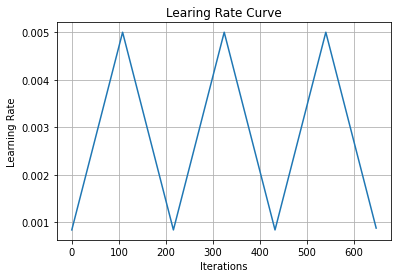

In [13]:
from pyTorchChitra.utils.CLR_data_calc import TriangularWavePlotter
plotter = TriangularWavePlotter(step_size = 108, min_bound = 0.00084, max_bound = 0.005)
plotter.generate_datapoints(num_curves = 3, draw_graph = True)

# Set the Arguments for project and Setup Train/Test Dataset 

In [0]:
# Arguments for the functions
class Args:
    # ---- Data Loader Arguments -----
    train_batch_size = 512
    test_batch_size = 512
    num_workers = 4
    dataset_mean = [0.4914, 0.4822, 0.4465]
    dataset_std = [0.2023, 0.1994, 0.2010]
    classes = ['plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class modelExtraSettings:
    '''Additional setting which are useful when debugging model '''
    RunLRFinder = False
    display_summary = True
  

In [15]:
# Get the Cifar-10 dataset and apply Ablumentation image augmentation techniques
train_loader, test_loader = cifar10WithAlbumentations(
                            batch_size = Args.train_batch_size, 
                            number_of_workers = Args.num_workers,
                            prob_transform = Args.num_workers  
                            )

Now downloading and allocating dataset
Cuda Available? cuda


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Now allocating Dataloaders


In [16]:
# Display the sample images. Images will be saved in current directory
displayDataSetSampleImages(train_loader, Args.classes,
                           Args.dataset_mean, Args.dataset_std, 
                           num_of_images = 20)

torch.Size([512, 32, 32, 3])


<Figure size 720x720 with 0 Axes>

# Train the Model

In [17]:
device = isCudaAvailable()
print (device)

cuda


In [0]:
#from pyTorchChitra.cnnModels.vanillaCNN import plainArch

In [19]:
from pyTorchChitra.cnnModels.new_resnet import PrintMyFileVersion
PrintMyFileVersion()

model = NewResNet().to(device)
if modelExtraSettings.display_summary == True:
    displayModelSummary(model)

Hello there it is 1.4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 256, 16, 16]         294,912
        MaxPool2d-11            [-1, 256, 8, 8]               0
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 512, 8, 8]       1,179,648
        MaxPool2d

./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)


In [0]:
import torch.nn as nn
from torch.optim import SGD, Adam

if modelExtraSettings.RunLRFinder == True:
    criterion = nn.NLLLoss()
    optimizer = SGD(model.parameters(), lr=0.0001)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=3, num_iter=1000, step_mode="exp")


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)



Learning rate search finished. See the graph with {finder_name}.plot()


0.0065048023980301024


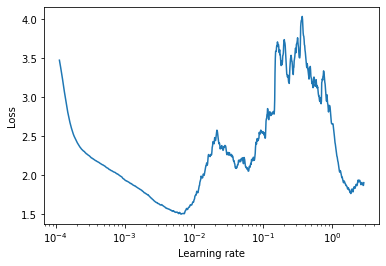

In [0]:
if modelExtraSettings.RunLRFinder == True:
    lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
    print (lr)
    lr_finder.plot()

In [0]:
optimizer, scheduler = setup_OCLR_Optimizer(model, device, total_steps = 2400, 
                                            num_raise = 0.209,div_factor = 6, max_lr = 0.005)

In [21]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.0008333333333333334


In [22]:
train_losses, train_acc, test_losses, test_acc = runTheModel(model=model, 
                                                            device=device, 
                                                            optimizer=optimizer, 
                                                            train_loader=train_loader, 
                                                            test_loader=test_loader, 
                                                            scheduler=scheduler,
                                                            epochs = 24, 
                                                            isOCLR = True,
                                                            )


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)
Loss=1.2565462589263916 Batch_id=97 Accuracy=39.85: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.2506, Accuracy: 5461/10000 (54.61%)
Validation loss to Schedular = 1.250629852294922

EPOCH: 1


Loss=1.0121666193008423 Batch_id=97 Accuracy=60.25: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0762, Accuracy: 6186/10000 (61.86%)
Validation loss to Schedular = 1.0762042663574218

EPOCH: 2


Loss=0.8003827333450317 Batch_id=97 Accuracy=68.48: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8936, Accuracy: 6863/10000 (68.63%)
Validation loss to Schedular = 0.8936116516113282

EPOCH: 3


Loss=0.7816463708877563 Batch_id=97 Accuracy=73.41: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8111, Accuracy: 7174/10000 (71.74%)
Validation loss to Schedular = 0.8110554336547852

EPOCH: 4


Loss=0.6419629454612732 Batch_id=97 Accuracy=76.94: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7636, Accuracy: 7403/10000 (74.03%)
Validation loss to Schedular = 0.763638166809082

EPOCH: 5


Loss=0.4891048073768616 Batch_id=97 Accuracy=80.18: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7036, Accuracy: 7548/10000 (75.48%)
Validation loss to Schedular = 0.7036487457275391

EPOCH: 6


Loss=0.5906519889831543 Batch_id=97 Accuracy=82.86: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6347, Accuracy: 7809/10000 (78.09%)
Validation loss to Schedular = 0.6347394317626953

EPOCH: 7


Loss=0.42405736446380615 Batch_id=97 Accuracy=85.03: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6262, Accuracy: 7923/10000 (79.23%)
Validation loss to Schedular = 0.6261702362060547

EPOCH: 8


Loss=0.3137282729148865 Batch_id=97 Accuracy=86.98: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6685, Accuracy: 7749/10000 (77.49%)
Validation loss to Schedular = 0.6684603973388672

EPOCH: 9


Loss=0.3121385872364044 Batch_id=97 Accuracy=88.28: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6099, Accuracy: 8036/10000 (80.36%)
Validation loss to Schedular = 0.6098526351928711

EPOCH: 10


Loss=0.28198951482772827 Batch_id=97 Accuracy=90.21: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6163, Accuracy: 7954/10000 (79.54%)
Validation loss to Schedular = 0.6162742919921875

EPOCH: 11


Loss=0.2673841714859009 Batch_id=97 Accuracy=91.21: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5681, Accuracy: 8136/10000 (81.36%)
Validation loss to Schedular = 0.5681432647705078

EPOCH: 12


Loss=0.20061925053596497 Batch_id=97 Accuracy=92.82: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5455, Accuracy: 8221/10000 (82.21%)
Validation loss to Schedular = 0.5454682952880859

EPOCH: 13


Loss=0.205452099442482 Batch_id=97 Accuracy=93.74: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5432, Accuracy: 8247/10000 (82.47%)
Validation loss to Schedular = 0.5432041809082031

EPOCH: 14


Loss=0.15604016184806824 Batch_id=97 Accuracy=94.61: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5524, Accuracy: 8222/10000 (82.22%)
Validation loss to Schedular = 0.5524483200073242

EPOCH: 15


Loss=0.13827908039093018 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5964, Accuracy: 8138/10000 (81.38%)
Validation loss to Schedular = 0.5964081802368164

EPOCH: 16


Loss=0.12284687906503677 Batch_id=97 Accuracy=96.07: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5305, Accuracy: 8327/10000 (83.27%)
Validation loss to Schedular = 0.5305122665405273

EPOCH: 17


Loss=0.13116894662380219 Batch_id=97 Accuracy=96.76: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5751, Accuracy: 8267/10000 (82.67%)
Validation loss to Schedular = 0.5751297241210938

EPOCH: 18


Loss=0.10225888341665268 Batch_id=97 Accuracy=96.87: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5882, Accuracy: 8252/10000 (82.52%)
Validation loss to Schedular = 0.5881843811035157

EPOCH: 19


Loss=0.09688402712345123 Batch_id=97 Accuracy=97.39: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5503, Accuracy: 8308/10000 (83.08%)
Validation loss to Schedular = 0.550257536315918

EPOCH: 20


Loss=0.11923889815807343 Batch_id=97 Accuracy=97.70: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5360, Accuracy: 8385/10000 (83.85%)
Validation loss to Schedular = 0.5360401000976562

EPOCH: 21


Loss=0.07273752242326736 Batch_id=97 Accuracy=98.06: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5536, Accuracy: 8326/10000 (83.26%)
Validation loss to Schedular = 0.5536054031372071

EPOCH: 22


Loss=0.04983599856495857 Batch_id=97 Accuracy=98.26: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5667, Accuracy: 8288/10000 (82.88%)
Validation loss to Schedular = 0.5667333038330078

EPOCH: 23


Loss=0.05039907246828079 Batch_id=97 Accuracy=98.54: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]


Test set: Average loss: 0.5286, Accuracy: 8408/10000 (84.08%)
Validation loss to Schedular = 0.528599552154541



2352


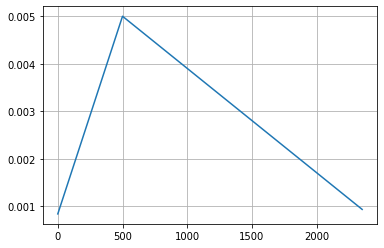

In [23]:
import matplotlib.pyplot as plt
from pyTorchChitra.utils.global_vars import cyclic_LR_history

print(len(cyclic_LR_history))
plt.plot(cyclic_LR_history)
plt.grid('both')

In [24]:
# Final Test Accuracy
test_acc[-1]

84.08

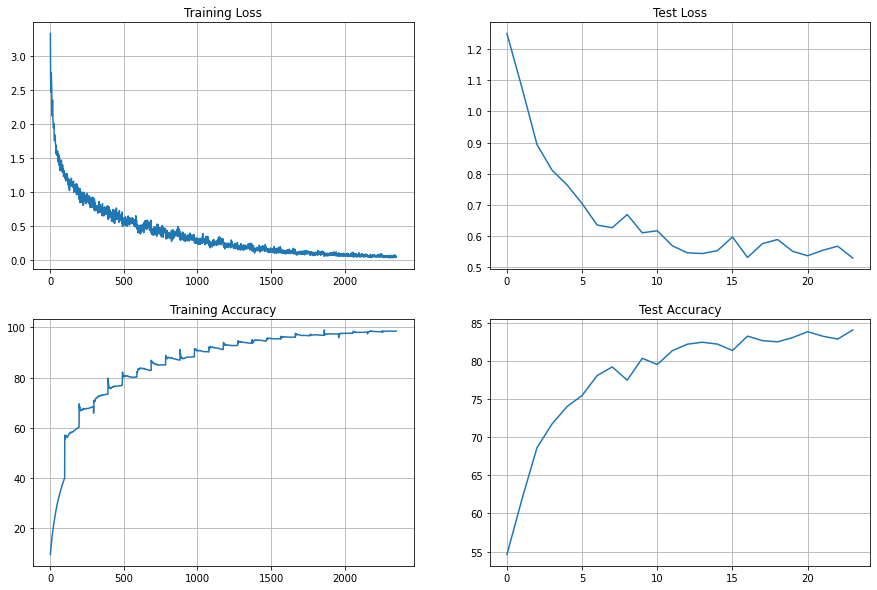

In [26]:
modelTrainTestHistory (train_losses, train_acc, test_losses, test_acc)

In [0]:
import torch
torch.save(model, './gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

In [0]:
#import torch
#torch.load('./gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

# Displaying the mis-classified images

In [28]:
ground_truth, classified_lie, my_misclassified_images = misClassfied(model=model, 
                                                                device=device, 
                                                                test_loader=test_loader, 
                                                                req_num_images=25)

ground_truth = ground_truth.numpy().squeeze().astype(int)
classified_lie = classified_lie.numpy().squeeze().astype(int)

# Not showing the mis-classified image here as it will be shown in GradCam
# Bug:<To-do>: displayMisClassfiedImages function de-normalizes the image; if the 'my_misclassified_images' sent as is to
# to the gradCam then images will fade
# displayMisClassfiedImages (ground_truth, Args.dataset_mean, Args.dataset_std, classified_lie, my_misclassified_images)

./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)


In [0]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']

grad_cam = GradCAMView(
    model, layers,
    device, Args.dataset_mean, Args.dataset_std,
)

gradcam_views = grad_cam(my_misclassified_images)

In [0]:
plot_gradcam(gradcam_views, layers, ground_truth, classified_lie, 'grad_cam')